# Load the data

In [1]:
# Import necessary packages
using DrWatson
using JLD2

# Activate the project environment
@quickactivate :FlowComplexity

# Define the file path
file_path = joinpath("./data", "data.jld2")

# Load the data from the specified file
@load file_path sim_array

1-element Vector{Symbol}:
 :sim_array

# Show time series for all chemostats of simulation no. X

In [ ]:
sim_array[90].sim_number
sim_array[90].time_evolution[1][:complete_timeseries]

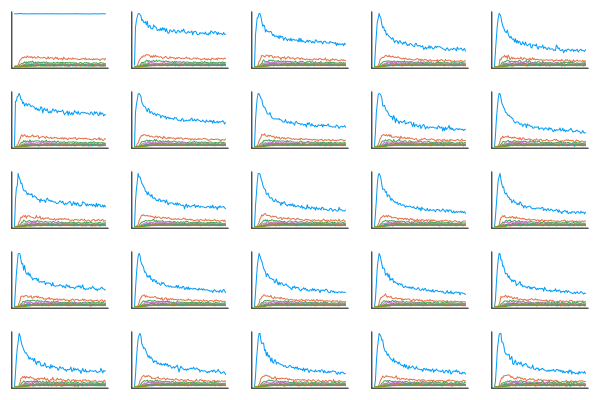

In [2]:
using DataFrames, Plots, FileIO

sim_no = 90
sim = sim_array[sim_no]
nchem = 25

# Define the array that will hold our population time series
max_t = Int(sim.total_time) + 1 # our sim goes to 0...100 so index has to go 1...101
nspecies = 10
pop_array = zeros(Int, nchem, max_t, nspecies)

# Convert the time series to a DataFrame
time_series_df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)

# Populate the population array using efficient DataFrame operations
for row in eachrow(time_series_df)
    
    i = Int(row[:reactor])
    j = round(Int, row[:time]) + 1 # indexing starts at 1
    k = parse(Int, row[:variable]) # to account for absent data (i.e., zero)
    if k > nspecies
        continue
    end
    # println(row)
    # println("i=$i j=$j k=$k")
    pop_array[i, j, k] = row[:value]
end

# Create a 3x3 grid plot
plot_grid = plot(layout = (5, 5))

# Loop over each subplot
for i in 1:nchem
    # Extract the time series data for the i-th plot
    time_series_data = pop_array[i, :, :]
    
    # Create a subplot for each species in the time series
    p = plot()
    for j in 1:nspecies
        # plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none)
        plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none, xlabel="", ylabel="", xticks=false, yticks=false)
    end
end

display(plot_grid)
# savefig(plot_grid, "./plots/ts-gridplot.pdf")

# Get the final populations

In [3]:
using DataFrames, Plots, FileIO, Statistics

first_sim = sim_array[1]
nsims = 100
nchem = 25
nspecies = 10
t = 100

ts_array = []

for i in 1:nsims
    sim = sim_array[i]
    df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
    df = filter(row -> row[:time] == t, df)
    df.variable = parse.(Int, df.variable) # convert variable to ints
    push!(ts_array, df)
end

# Dimensionality reduction (time, chemostats)

In [4]:
# drop the time
for i in 1:nsims
    df = ts_array[i]
    df_new = select(df, Not(:time))
    ts_array[i] = df_new
end

In [5]:
# drop the chemostats (by combining the frequencies of each integer across all of them)
for i in 1:nsims
    df = ts_array[i]
    result = combine(groupby(df, :variable), :value => sum)
    ts_array[i] = result
end

# Calculate the abundance

In [6]:
for i in 1:nsims
    df = ts_array[i]
    total_value = sum(df.value_sum)
    df.abundance = df.value_sum ./ total_value
    ts_array[i] = df
end

# Determine the maximum complexity of molecules above some abundance threshold

In [7]:
function find_highest_molecule(df, threshold)
    # Define the threshold
    X = threshold

    # Filter the DataFrame to get rows where abundance is greater than X
    filtered_df = filter(row -> row.abundance > X, df)

    # Check if there are any rows that meet the condition
    if nrow(filtered_df) > 0
        # Find the row with the maximum "variable" value
        highest_molecule = maximum(filtered_df.variable)
    else
        highest_molecule = NaN
    end

    return highest_molecule
end

find_highest_molecule (generic function with 1 method)

In [49]:
threshold_arr = exp10.(LinRange(-5,-1,5))

n_thresholds = length(threshold_arr)
highest_molecules = fill(NaN, n_thresholds, nsims)

for i in 1:n_thresholds
    for j in 1:nsims
        threshold = threshold_arr[i]
        df = ts_array[j]
        highest_molecule = find_highest_molecule(df, threshold)
        highest_molecules[i, j] = highest_molecule
    end
end

In [50]:
# get the outflow_rates
kd_arr = zeros(nsims)

for i in 1:nsims
    kd_arr[i] = sim_array[i].all_constants[1,3]
end

In [51]:
# convert the integers to assembly indices
using CSV
using DataFrames

# Specify the path to the CSV file
file_path = "./data/Assembly-10000.csv"

# Read the CSV file into a DataFrame
AI_df = CSV.read(file_path, DataFrame)

function int_to_A(integer)
    row_index = findfirst(AI_df.integer .== integer)
    A = AI_df.assemblyindex[row_index]
    return A
end

int_to_A (generic function with 1 method)

In [52]:
highest_A = copy(highest_molecules)

for i in eachindex(highest_A)
    highest_A[i] = int_to_A(highest_molecules[i])
end

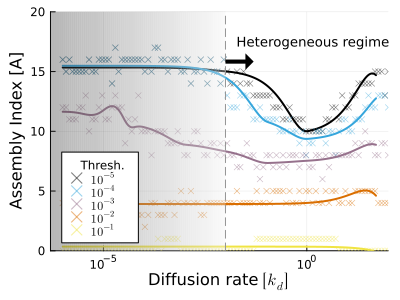

"/Users/alexandre/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/milestones/04_mu(m)-vs-kd/A_kdmax-1e2/plots/abundance.pdf"

In [603]:
using Printf, LaTeXStrings, ColorSchemes

using Dierckx, Interpolations

gr()

s = scatter(size=(400,300), 
            xscale=:log10, xlabel="Diffusion rate " * L"[k_d]", ylabel="Assembly Index " * "[A]", 
            xlim=(5e-7, 1e2), ylim=(0,20),
            legendtitle="Thresh.", legendtitlefontsize=8, legend=:bottomleft)

labels = [L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", ]
markers = [:x, :+, :utriangle, :square, :star5, :x, :+]

for i in 1:n_thresholds
    x = kd_arr
    y = highest_A[i,:]

    label = @sprintf("%.1e", threshold_arr[i])
    color = get(ColorSchemes.mk_8, (i - 1) / (n_thresholds - 1))
    scatter!(s, x, y, marker=:x, markersize=3, color=color, alpha=0.50, label=labels[i])

    xmin = minimum(x)
    xmax = maximum(x)
    xlogmin = log10(xmin)
    xlogmax = log10(xmax)
    # little hack below because the splines behave weirdly towards the higher x values
    xlogmax -= 0.3
    xfine = exp10.(LinRange(xlogmin,xlogmax,1000))

    smoothing_param = 55.0
    spl = Spline1D(x, y, s=smoothing_param, k=3, bc="error")
    plot!(s, xfine, spl.(xfine), linewidth=2, color=color, alpha=1.00, label=:none)
end

vline!([1e-2], linestyle=:dash, color=:gray, label=:none)
annotate!(2e-2, 17.5, text("Heterogeneous regime", :left, 9))
annotate!(1e-2, 16., text("➞", :left, 26))
arr = Plots.Arrow(:closed, :head, 1., 1.)
GR.setarrowsize(10)
yarr = 16.0

# create a shaded area showing the transition
x = exp10.(LinRange(-7, -2, 100))
y1 = zeros(length(x))  # y = 0
y2 = fill(20, length(x))  # y = 20
plot!(s, x, y2, fillrange=y1, fill_z=log10.(x), c=:grays, label="", colorbar=false, lw=0, alpha=0.35)

display(s)
savefig("./plots/abundance.pdf")



# Plot the mass against the diffusion coefficient

In [18]:
total_mass = zeros(nsims)

for i in 1:nsims
    df = ts_array[i]
    m = sum(df.variable .* df.value_sum)
    total_mass[i] = m
end

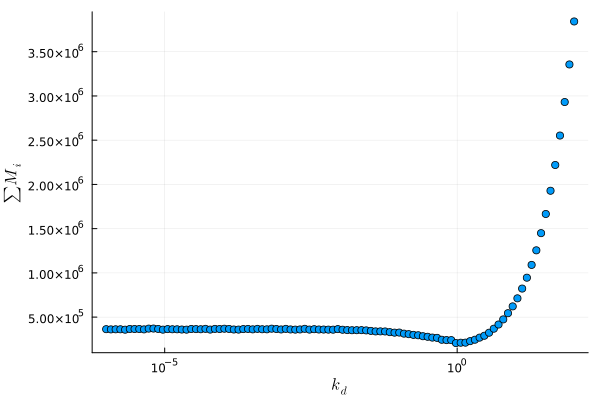

"/Users/alexandre/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/milestones/04_mu(m)-vs-kd/A_kdmax-1e2/plots/mass.pdf"

In [450]:
using LaTeXStrings

kd_arr = exp10.(LinRange(-6,2,nsims))

m = scatter(xlabel=L"k_d", ylabel=L"\sum M_i", legend=:none,
            xscale=:log10)
scatter!(m, kd_arr, total_mass)

display(m)
savefig("./plots/mass.pdf")